In [104]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

# Qiskit imports
# from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="DIN NYCKEL HÄR",overwrite = True)
service = QiskitRuntimeService()



In [105]:
num_qubits = 5
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend

<IBMBackend('ibm_brussels')>

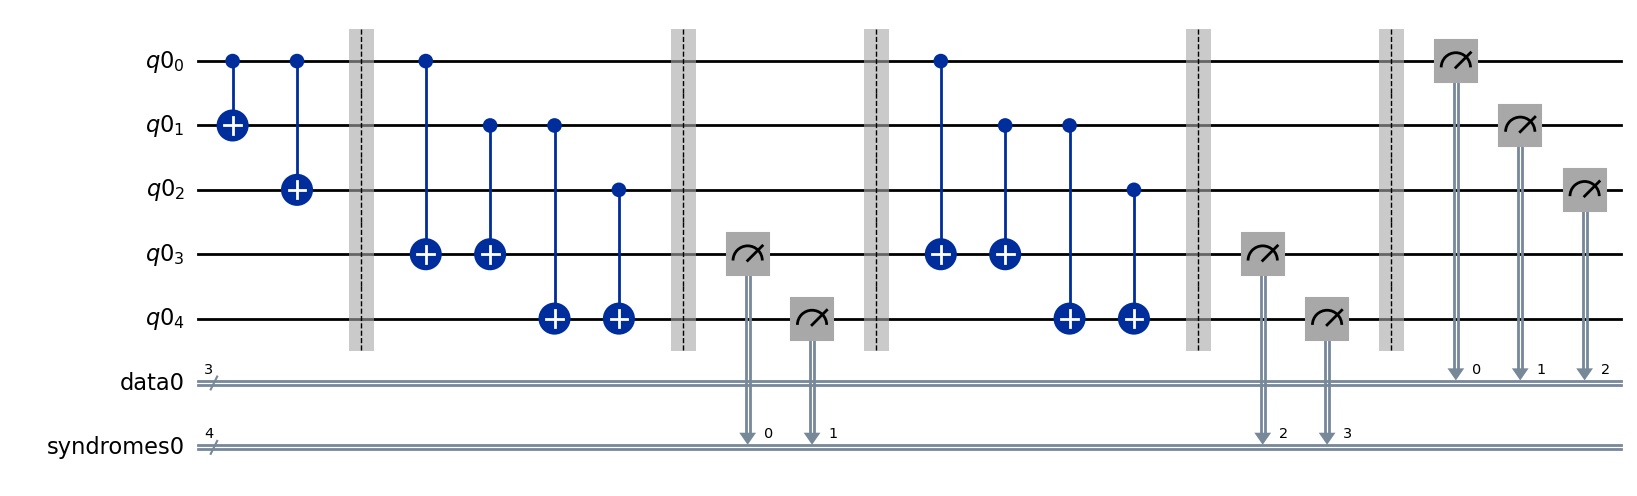

In [106]:


def gen_circuit(k=1, d=3, n_measure = 1):

    # qubits ordered by logical qubit
    qreg_q = [QuantumRegister(2*d-1, f"q{i}") for i in range(k)]

    # Data register ordered by logical qubit
    creg_data = [ClassicalRegister(d, f"data{i}") for i in range(k)]

    # Syndrome register ordered by logical qubit with capacity for multiple measurements
    creg_syndromes = [ClassicalRegister((d-1)*n_measure, f"syndromes{i}") for i in range(k)]
    
    circuit = QuantumCircuit(*qreg_q, *creg_data, *creg_syndromes)


    for i in range(k):

        # Entangle redundancy qubits
        for j in range(1,d):
            circuit.cx(qreg_q[i][0], qreg_q[i][j])

        # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
        circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for m in range(n_measure):
            # Stabilizer computation
            for j in range(d-1):
                circuit.cx(qreg_q[i][j], qreg_q[i][d+j])
                circuit.cx(qreg_q[i][j+1], qreg_q[i][d+j])

            # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

            # Measure syndrome
            for j in range(d-1):
                circuit.measure(qreg_q[i][j+d], creg_syndromes[i][j+(d-1)*m])

        
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for j in range(d):
            circuit.measure(qreg_q[i][j], creg_data[i][j])
        # circuit.measure(qreg_q[1], creg_data[1])
        # circuit.measure(qreg_q[2], creg_data[2])

    return circuit


circuit = gen_circuit(1,3, 2)

circuit.draw(output="mpl", style='iqp')




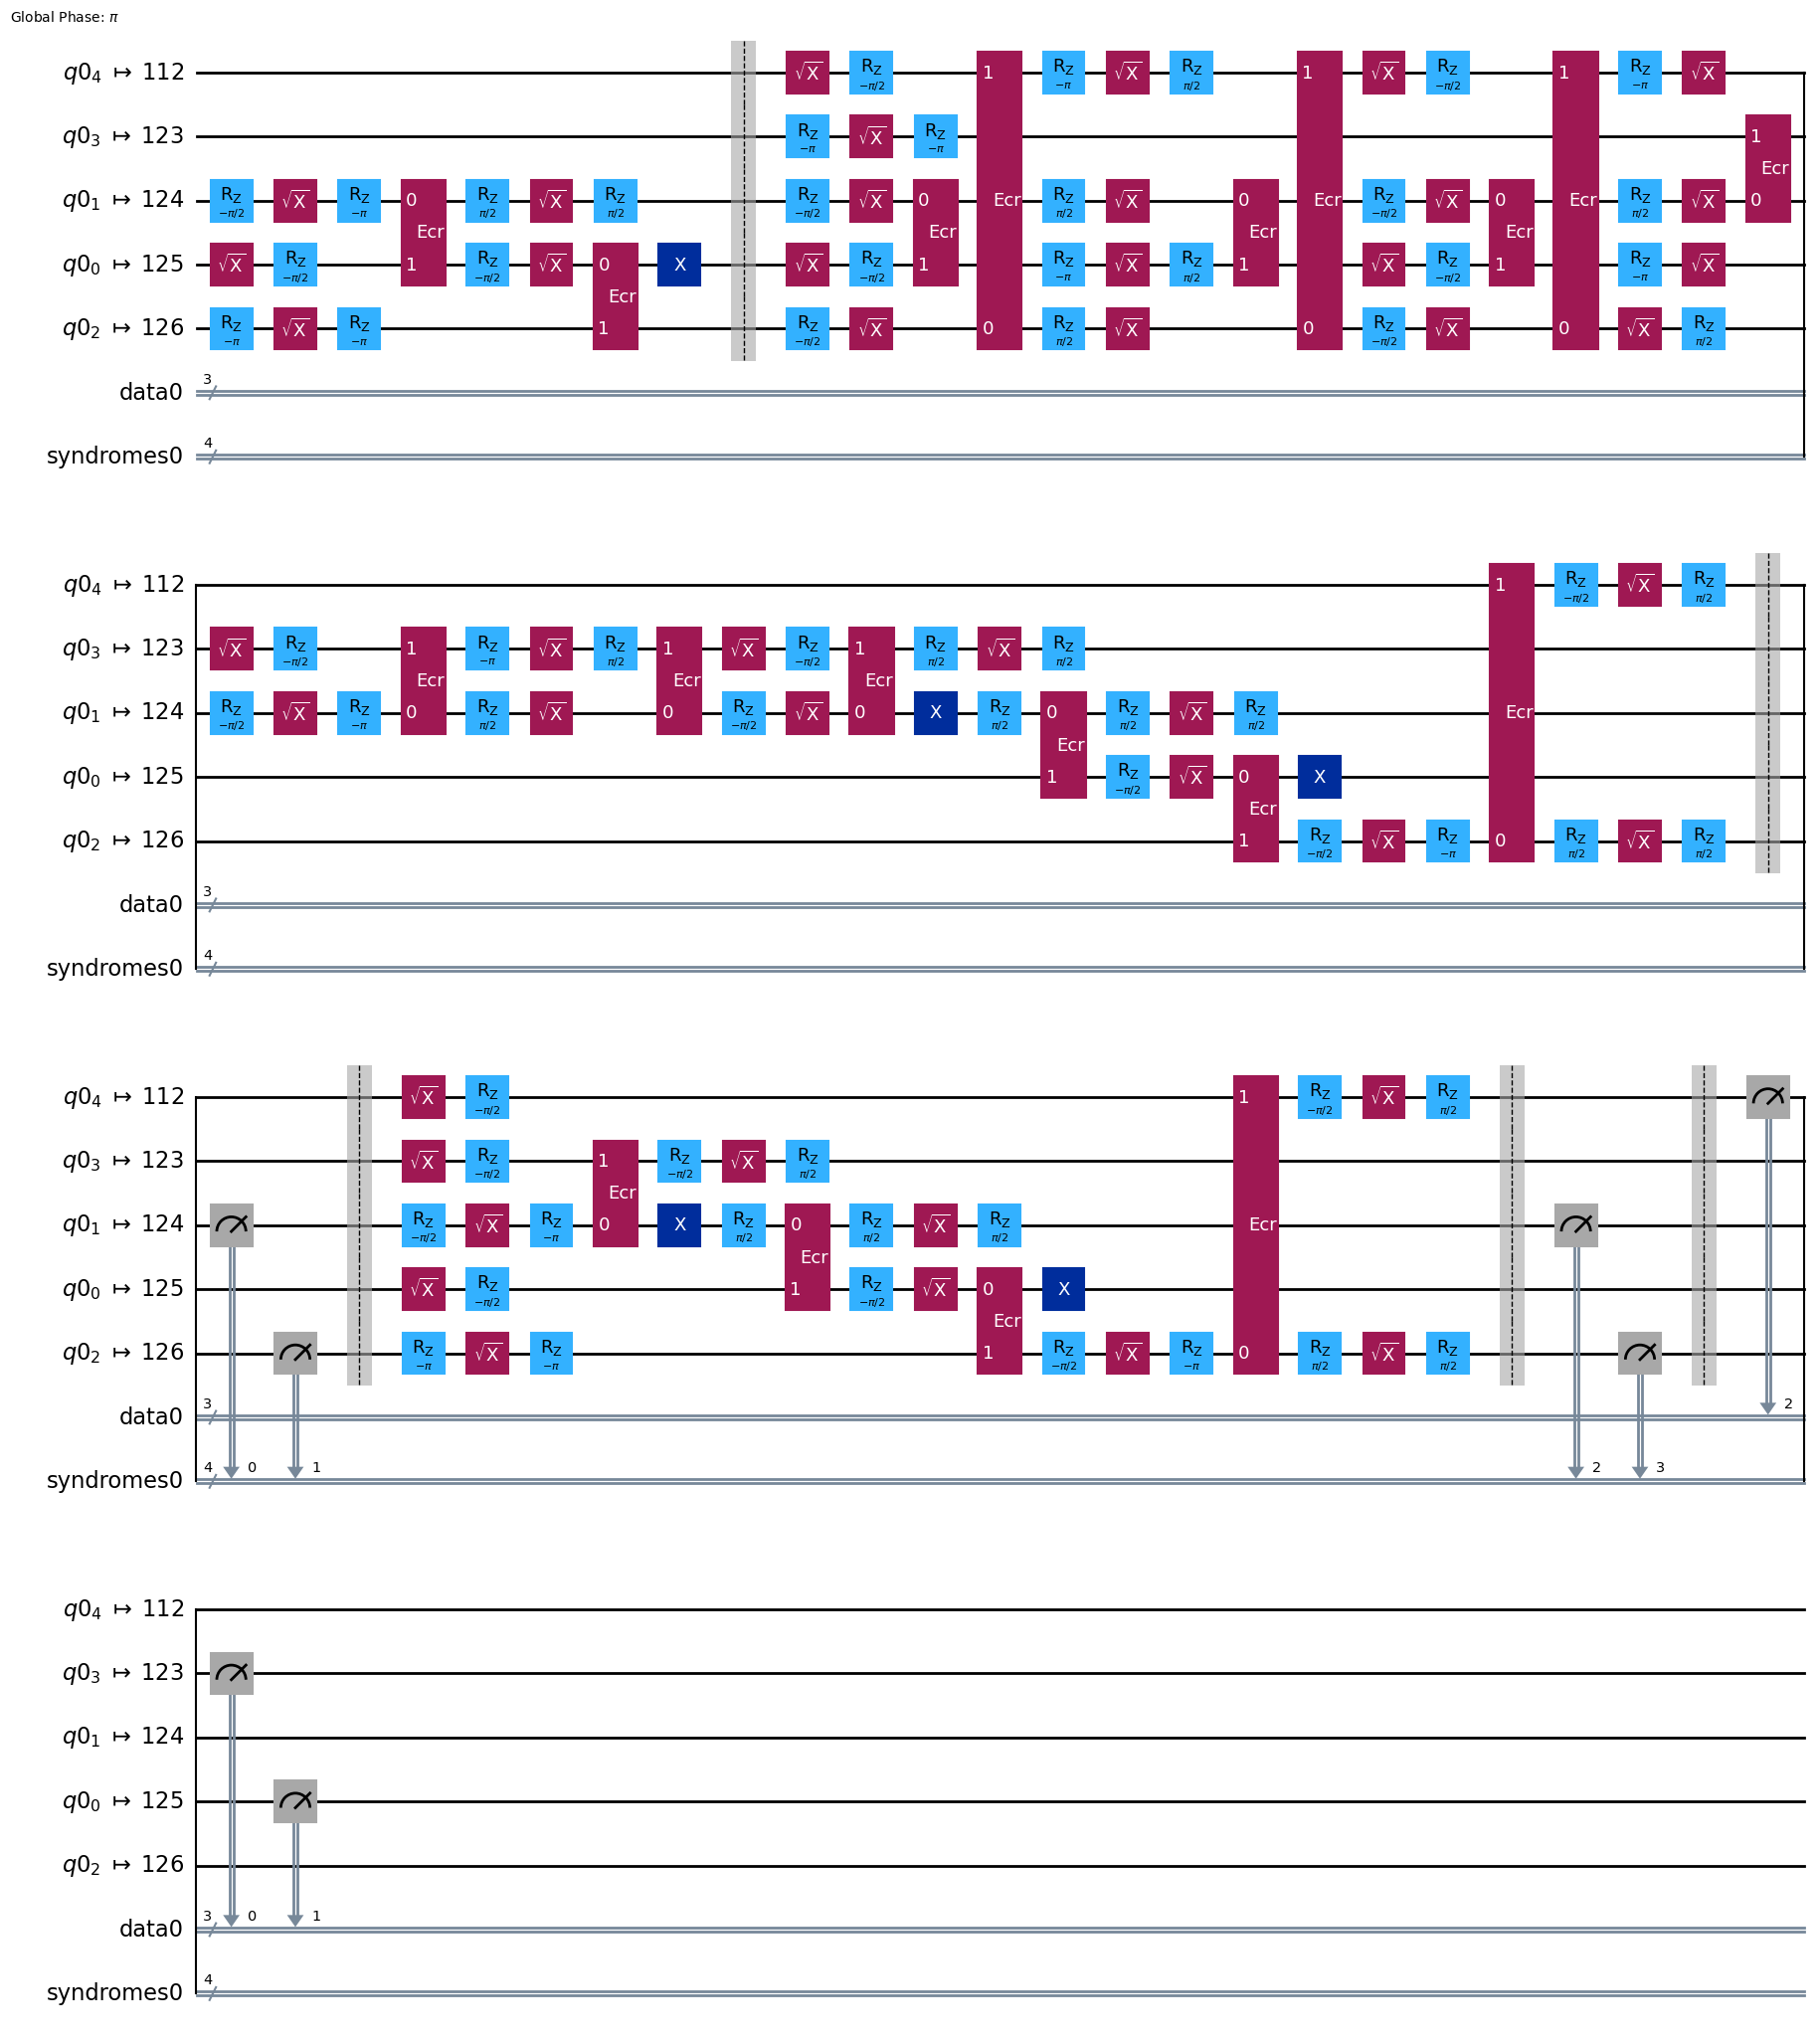

In [107]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [110]:
sampler_no_correction = Sampler(backend)
job_no_correction = sampler_no_correction.run([isa_circuit], shots=1000)
result_no_correction = job_no_correction.result()[0]

In [109]:
print(f"Data (no correction):\n{result_no_correction.data.data0.get_counts()}")
print(f"Syndrome (no correction):\n{result_no_correction.data.syndromes0.get_counts()}")

Data (no correction):
{'000': 437, '001': 115, '010': 275, '011': 117, '111': 11, '100': 22, '101': 8, '110': 15}
Syndrome (no correction):
{'0100': 101, '0101': 87, '0000': 243, '1011': 21, '0011': 215, '0111': 92, '0010': 46, '1110': 8, '0001': 55, '1101': 12, '1111': 20, '1001': 16, '0110': 38, '1000': 23, '1010': 21, '1100': 2}
